In [36]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import os, sys
os.chdir("..")
from src.kernel_hedger import *
from src.Ito_SigKer import ItoKer
from src.utils import *
from src.simulators import *
from src.alpha_decay import *
import yfinance as yf


if torch.cuda.is_available(): 
  device = 'cuda'
else: 
  device = 'cpu'

print('device:', device)

device: cpu


# Data Creation

$$X_t = X_t$$
$$Y_t = X_t + Z_t$$

with $X_t$ a 0-drift GBM and Z a 0-mean OU process.


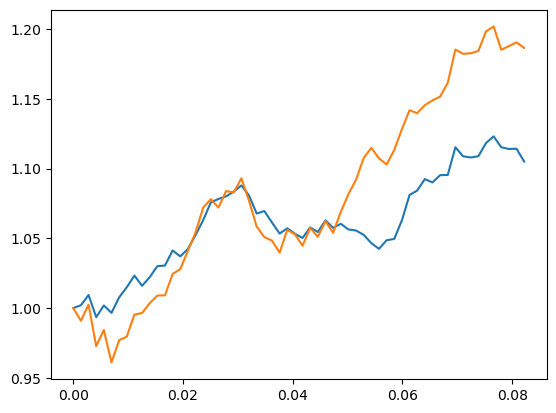

In [37]:
#torch.manual_seed(0)
batch_x, batch_y, timesteps, d = 100, 10, 60, 1
sigma, S0, T = 0.2, 1.0, 30./365 # Black Scholes parameters
theta, mu, std = 10, 0.0, 0.2


dt = T/timesteps
time_grid = torch.linspace(0.0, T, timesteps).view(1, -1, 1).expand([batch_x + batch_y, timesteps, d])

dW = np.sqrt(dt)*torch.randn(batch_x + batch_y, timesteps-1, d, 2)
W = torch.cat((torch.zeros(batch_x + batch_y, 1, d), dW[..., 0].cumsum(dim=1)), dim = 1)

X = S0*torch.exp(-0.5*(sigma**2)*time_grid + sigma*W).to(device)

Z = torch.zeros(X.shape).to(X.device.type)
for t in range(Z.shape[1]-1):
    Z[:, t+1, :] = Z[:, t, :] - theta*(mu - Z[:, t, :])*dt + std*dW[:, t, :, -1]


paths = torch.cat([X, X+Z], dim=-1)
train_paths = paths[:batch_x]
test_paths = paths[batch_x:]

plt.plot(torch.linspace(0.0, T, timesteps), train_paths[0].detach().cpu())
plt.show()

# Model Instantiation

In [38]:
class ItoSigKer(KernelCompute):
    def __init__(self):
        self.Kernel_Class = ItoKer()
        
    def compute_Gram(self, X, Y, sym=False):
        return self.Kernel_Class.compute_Gram(X,Y)
    
    def eta_square(self, X, time_augmented=False, max_batch=50):
        return super().eta_square(X, time_augmented, max_batch)

In [50]:
Ker = ItoSigKer()

sk_trade = SigKernelTrader(Ker,
                           0.5,
                           device='cpu', time_augment=True,
                           dyadic_order=0)

sk_trade.pre_fit(train_paths)

100%|██████████| 59/59 [00:02<00:00, 28.70it/s]


In [51]:
sk_trade.fit(reg_type='L2', regularisation=3e-16)
sk_trade.compute_pnl(train_paths)

Alpha Obtained: 0.0024521350860595703


100%|██████████| 59/59 [00:01<00:00, 30.76it/s] 


Test PnL Obtained: 0.0027930736541748047


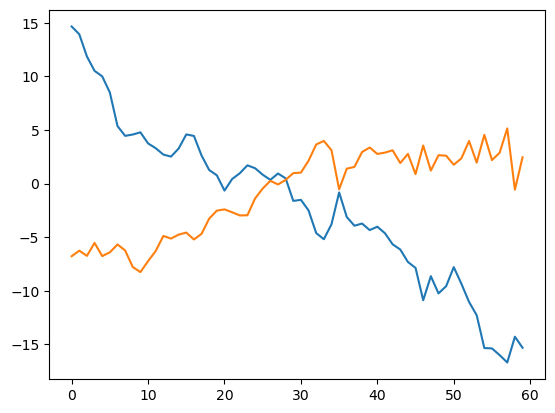

In [52]:
plt.plot(sk_trade.position[6])

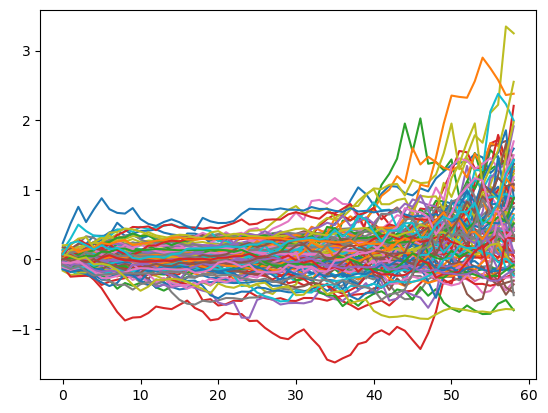

In [53]:
for i in range(sk_trade.pnl.shape[0]):
    plt.plot(sk_trade.pnl[i])

(array([ 5., 22., 26., 14., 13., 12.,  4.,  2.,  1.,  1.]),
 array([-0.73188913, -0.33402422,  0.0638407 ,  0.46170561,  0.85957052,
         1.25743543,  1.65530035,  2.05316526,  2.45103017,  2.84889509,
         3.24676   ]),
 <BarContainer object of 10 artists>)

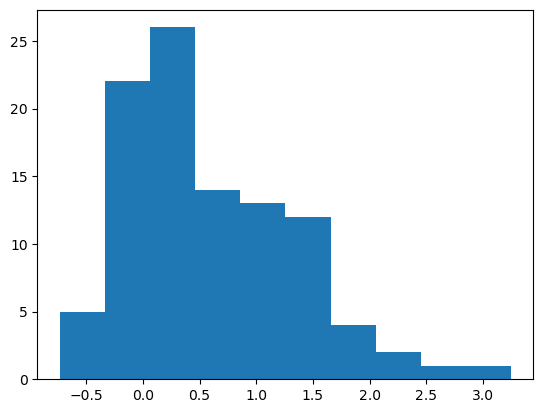

In [54]:
plt.hist(sk_trade.pnl[:,-1])

In [55]:
sk_trade.pnl.shape

torch.Size([100, 59])